In [64]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
dir_in_Lx = '../out/20.0518 Lx/L100only_reg_rf_boruta_all/'

y_compr_tr = pickle.load(open(os.path.join(dir_in_Lx, 'anlyz', 'y_compr_tr.pkl'), 'rb'))
y_compr_te = pickle.load(open(os.path.join(dir_in_Lx, 'anlyz', 'y_compr_te.pkl'), 'rb'))

## Overall

[Text(0.5, 0, 'Actual'), Text(0, 0.5, 'Predicted'), (-3.0, 2.0), (-3.0, 2.0)]

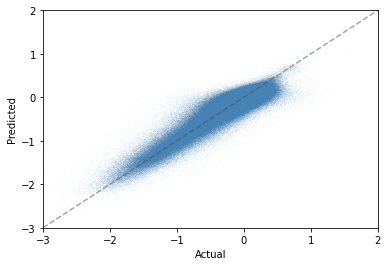

In [10]:
plt.figure()
plt.plot([-3,2], [-3,2], ls="--", c=".3", alpha=0.5)
ax = sns.scatterplot(y_compr_te['actual'].values.flatten(), y_compr_te['predicted'].values.flatten(),
                     s = 1, alpha=0.05, linewidth=0, color='steelblue')
ax.set(xlabel='Actual', ylabel='Predicted', xlim=[-3,2], ylim=[-3,2])

In [286]:
# get the R2 scores
df_scores = pd.read_csv('%s/anlyz/agg_summary.csv' % dir_in_Lx, index_col=0)

In [382]:
# get actual/predicted from model
actual = pd.melt(y_compr_te['actual'])
actual = actual.rename(columns={'variable':'gene'})
actual.set_index('gene', drop=True, inplace=True)
pred = pd.melt(y_compr_te['predicted'])
pred = pred.rename(columns={'variable':'gene'})
pred.set_index('gene', drop=True, inplace=True)
df = pd.concat([actual,pred], axis=1)
df.columns = ['actual', 'predicted']
df_merged = df.merge(dep_class, left_index=True, right_index=True)
df_merged.columns = ['actual', 'predicted', 'class']

### correlation
Compare the CERES score ranges between actual and predicted

In [150]:
dm_data_pkl_file = '../out/20.0817 proc_data/gene_effect/dm_data.pkl'
dm_data = pickle.load(open(dm_data_pkl_file,'rb'))

In [169]:
df_crispr = dm_data.df_crispr.copy()
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values

In [207]:
def getCalc(x):
    return max(x)-min(x)

In [208]:
range_actual = df_crispr.apply(lambda x: getRange(x), axis=0)

In [209]:
range_pred = df_merged.groupby('gene').apply(lambda x: getCalc(x['predicted']))

[Text(0.5, 0, 'actual CERES range'), Text(0, 0.5, 'predicted CERES range')]

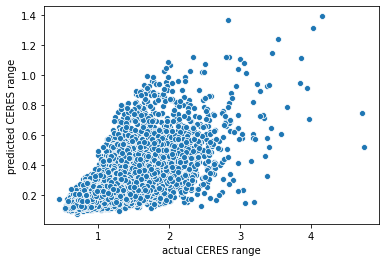

In [210]:
ax = sns.scatterplot(range_actual, range_pred)
ax.set(xlabel='actual CERES range', ylabel='predicted CERES range')

### How many models are predicting just more/less a constant?

In [383]:
df_merged['gene'] = df_merged.index

In [384]:
def getRange(x):
    return max(x)-min(x)

In [385]:
pred_range = df_merged.groupby('gene').apply(lambda x: getRange(x['predicted']))
pred_range = pred_range.rename('0')

<AxesSubplot:ylabel='Frequency'>

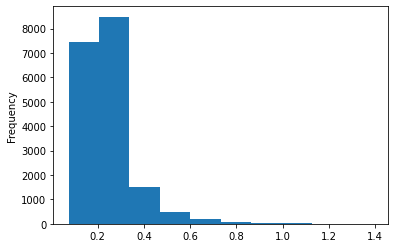

In [162]:
pred_range.plot.hist()

In [163]:
c = (pred_range < 0.45).sum()
pct = c / len(pred_range)
print("total number of models that's predicting more or less constants: %d" % c)
print("%% of models that's predicting more or less constants: %.2f" % pct)

total number of models that's predicting more or less constants: 17285
% of models that's predicting more or less constants: 0.95


In [212]:
c = (pred_range > 0.45).sum()
pct = c / len(pred_range)
print("total number of models that's predicting with differential values: %d" % c)
print("%% of models that's predicting with differential values: %.2f" % pct)

total number of models that's predicting with differential values: 943
% of models that's predicting with differential values: 0.05


### Check specific genes

In [213]:
gene_names = pred_range.index[(pred_range < 0.4) & (pred_range > 0.35)]

In [214]:
gene_names[1]

'ABCE1'

[Text(0.5, 0, 'actual'), Text(0, 0.5, 'predicted'), (-2.5, 1.0), (-2.5, 1.0)]

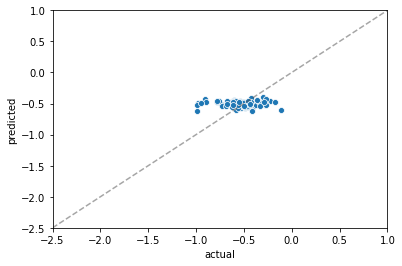

In [454]:
gene_name = 'AAAS'
res = pickle.load(open('%s/model_perf/y_compr_%s.pkl' % (dir_in_Lx, gene_name),'rb'))
df = res['te']
plt.plot([-2.5,1], [-2.5,1], ls="--", c=".3", alpha=0.5)
ax = sns.scatterplot(df.y_actual, df.y_pred)
ax.set(xlabel='actual', ylabel='predicted', xlim=[-2.5,1], ylim=[-2.5,1])

## Break down by class (based on strict cut-offs of CERES)

In [407]:
# alternatively get dependency class by gene effect cut-offs
dm_data_pkl_file = '../out/20.0817 proc_data/gene_effect/dm_data.pkl'
dm_data = pickle.load(open(dm_data_pkl_file,'rb'))

def classifyDep(x):
    if all(x < -0.5):
        return 'common_essential (<-0.5)'
    elif all((x < 0.5) & (x > -0.5)):
        return 'common_nonessential (near 0s)'
    else:
        return 'selective_essential (others)'

df_crispr = dm_data.df_crispr.copy()
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values
dep_class = df_crispr.apply(lambda x: classifyDep(x), axis=0)
dep_class = dep_class.rename('0')

In [408]:
dep_class.value_counts()

selective_essential (others)     15706
common_nonessential (near 0s)     2090
common_essential (<-0.5)           537
Name: 0, dtype: int64

In [409]:
dep_class.value_counts() / dep_class.shape[0] # percentage

selective_essential (others)     0.856706
common_nonessential (near 0s)    0.114002
common_essential (<-0.5)         0.029291
Name: 0, dtype: float64

Based on gene dependency: 42% of genes are common non-essential or common essential, but 95% of models are predicting more/less constants

Based on gene effect cut-off: 13% of genes are common non-essential or common essential, but 95% of models are predicting more/less constants

Based on gene dependency: 60% of genes are differential essential, but 5% of models are predicting differential values

Based on gene effect cut-off: 86% of genes are differential essential, but 5% of models are predicting differential values

In [410]:
# get actual/predicted from model
actual = pd.melt(y_compr_te['actual'])
actual = actual.rename(columns={'variable':'gene'})
actual.set_index('gene', drop=True, inplace=True)
pred = pd.melt(y_compr_te['predicted'])
pred = pred.rename(columns={'variable':'gene'})
pred.set_index('gene', drop=True, inplace=True)
df = pd.concat([actual,pred], axis=1)
df.columns = ['actual', 'predicted']

In [411]:
df_merged = df.merge(dep_class, left_index=True, right_index=True)
df_merged.columns = ['actual', 'predicted', 'class']

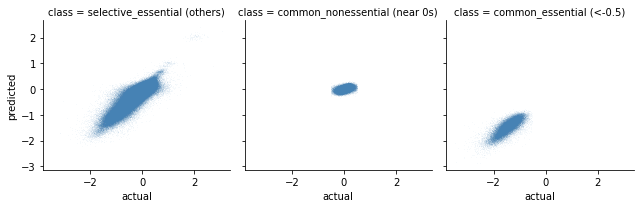

In [412]:
g = sns.FacetGrid(df_merged, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 1, alpha=0.05, linewidth=0, color='steelblue')

[Text(0.5, 0, 'Actual'), Text(0, 0.5, 'Predicted'), (-3.0, 2.0), (-3.0, 2.0)]

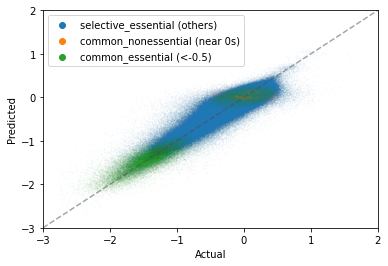

In [413]:
plt.figure()
plt.plot([-3,2], [-3,2], ls="--", c=".3", alpha=0.5)
ax = sns.scatterplot(x='actual', y='predicted', data=df_merged, hue=df_merged['class'].tolist(),
                     s = 1, alpha=0.05, linewidth=0)
ax.set(xlabel='Actual', ylabel='Predicted', xlim=[-3,2], ylim=[-3,2])

### Correlation
Compare the CERES score ranges between actual and predicted

In [414]:
df = pd.concat([range_actual, range_pred], axis=1)
df = df.merge(dep_class, left_index=True, right_index=True)
df.columns = ['actual','predicted','class']

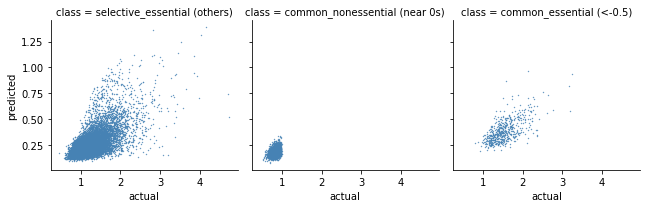

In [415]:
g = sns.FacetGrid(df, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 2, alpha=0.8, linewidth=0, color='steelblue')

In [416]:
from scipy.stats import spearmanr
def calcCorr(x):
    a = x.dropna()
    return spearmanr(a['actual'], a['predicted'])
    
df.groupby('class').apply(calcCorr)

class
common_essential (<-0.5)         (0.6038396622061843, 2.3064781986321825e-54)
common_nonessential (near 0s)    (0.3053620652494382, 2.6118512058051484e-46)
selective_essential (others)                        (0.5448403969117528, 0.0)
dtype: object

### Scores

In [417]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

/Users/boyangzhao/anaconda/envs/cnp/lib/python3.7/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


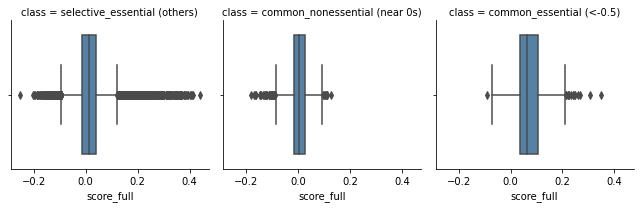

In [418]:
g = sns.FacetGrid(df, col="class")
g.map(sns.boxplot, 'score_full',color='steelblue')

In [419]:
df.groupby('class').apply(np.mean).T

class,common_essential (<-0.5),common_nonessential (near 0s),selective_essential (others)
score_full,0.072616,0.003595,0.017958
score_rd,-0.007796,-0.085481,-0.064358
score_rd10,-0.005399,-0.085601,-0.064761
corr_rd10,0.183033,0.043767,0.073179
recall_rd10,0.825728,0.602208,0.647948
p19q4_score_rd10,0.002387,-0.095095,-0.079520
p19q4_corr_rd10,0.185464,0.024873,0.059299
p19q4_recall_rd10,0.796603,0.549675,0.602584


In [424]:
df.groupby('class').aggregate(np.median).T

class,common_essential (<-0.5),common_nonessential (near 0s),selective_essential (others)
score_full,0.064255,0.00394,0.01306
score_rd,-0.01677,-0.08309,-0.06726
score_rd10,-0.01293,-0.080935,-0.06751
corr_rd10,0.17661,0.042405,0.062415
recall_rd10,0.935,0.641,0.707
p19q4_score_rd10,-0.004215,-0.08541,-0.07666
p19q4_corr_rd10,0.17737,0.02312,0.05163
p19q4_recall_rd10,0.8935,0.5695,0.647
pred_range,0.368793,0.181637,0.223533
constant,True,True,True


### Predicted range

In [420]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

df = df.merge(pred_range, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('pred_range')
df.columns = c

In [421]:
df['constant'] = df.pred_range<0.45

In [422]:
# number of models in each group that are constant models
df.groupby('class')['constant'].apply(sum)

class
common_essential (<-0.5)           403
common_nonessential (near 0s)     2088
selective_essential (others)     14794
Name: constant, dtype: int64

In [423]:
# % of models in each group that are constant models
df.groupby('class')['constant'].apply(lambda x: sum(x)/len(x))

class
common_essential (<-0.5)         0.754682
common_nonessential (near 0s)    1.000000
selective_essential (others)     0.947969
Name: constant, dtype: float64

Out of 18333 targets, 
- ~2K genes are mostly common non essentials: recall 0.64 | 100% models are constant models
- ~537 genes are mostly common essentials: recall 0.93 | 75% models are constant models
- ~15K genes are others: recall 0.7 | 95% models are constant models

## Break down by SD and range (and looser def of common non/essentials, allowing 1-2 genes outside of range)

In [473]:
# alternatively get dependency class by gene effect cut-offs
def classifyDep(x):
    n = len(x)
    if (np.std(x)>0.25) and ((max(x)-min(x))>0.6) and (sum(x<-0.5)>0):
        return 'selective essential (sd and range)'
    elif (n - sum((x < 0.5) & (x > -0.5))) < 3 :
        return 'mostly common_nonessential (near 0s)'
    if (n - sum(x < -0.5)) < 3:
        return 'mostly common_essential (<-0.5)'
    else:
        return 'Others'

df_crispr = dm_data.df_crispr.copy()
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values
df_crispr.columns = df_crispr.columns.str.extract('^(.*)\s').squeeze().values
dep_class = df_crispr.apply(lambda x: classifyDep(x), axis=0)
dep_class = dep_class.rename('0')

In [474]:
dep_class.value_counts()

Others                                  10021
mostly common_nonessential (near 0s)     7026
mostly common_essential (<-0.5)           703
selective essential (sd and range)        583
Name: 0, dtype: int64

In [475]:
dep_class.value_counts() / dep_class.shape[0] # percentage

Others                                  0.546610
mostly common_nonessential (near 0s)    0.383243
mostly common_essential (<-0.5)         0.038346
selective essential (sd and range)      0.031801
Name: 0, dtype: float64

In [476]:
# get actual/predicted from model
actual = pd.melt(y_compr_te['actual'])
actual = actual.rename(columns={'variable':'gene'})
actual.set_index('gene', drop=True, inplace=True)
pred = pd.melt(y_compr_te['predicted'])
pred = pred.rename(columns={'variable':'gene'})
pred.set_index('gene', drop=True, inplace=True)
df = pd.concat([actual,pred], axis=1)
df.columns = ['actual', 'predicted']
df_merged = df.merge(dep_class, left_index=True, right_index=True)
df_merged.columns = ['actual', 'predicted', 'class']

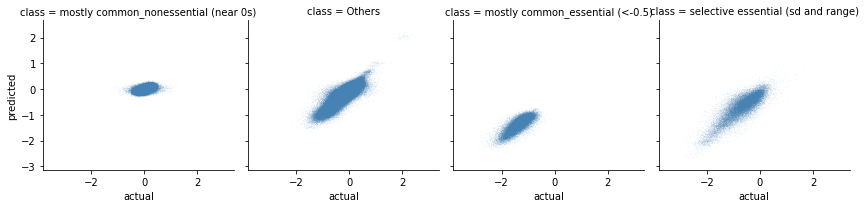

In [477]:
g = sns.FacetGrid(df_merged, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 1, alpha=0.05, linewidth=0, color='steelblue')

### Correlation
Compare the CERES score ranges between actual and predicted

In [478]:
df = pd.concat([range_actual, range_pred], axis=1)
df = df.merge(dep_class, left_index=True, right_index=True)
df.columns = ['actual','predicted','class']

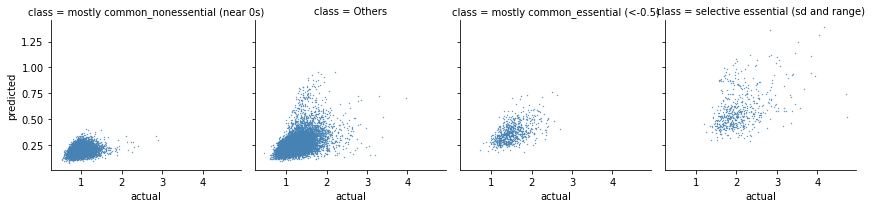

In [479]:
g = sns.FacetGrid(df, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 2, alpha=0.8, linewidth=0, color='steelblue')

In [480]:
from scipy.stats import spearmanr
def calcCorr(x):
    a = x.dropna()
    return spearmanr(a['actual'], a['predicted'])
    
df.groupby('class').apply(calcCorr)

class
Others                                                     (0.4875629303007906, 0.0)
mostly common_essential (<-0.5)          (0.512872035240081, 2.7538210042365766e-48)
mostly common_nonessential (near 0s)    (0.2898576238211376, 5.495224528348519e-136)
selective essential (sd and range)      (0.3821057737668896, 4.8354046015197925e-20)
dtype: object

### Scores

In [481]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

/Users/boyangzhao/anaconda/envs/cnp/lib/python3.7/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


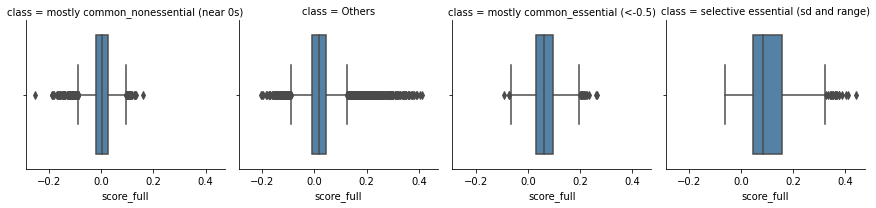

In [482]:
g = sns.FacetGrid(df, col="class")
g.map(sns.boxplot, 'score_full',color='steelblue')

In [483]:
df.groupby('class').apply(np.mean).T

class,Others,mostly common_essential (<-0.5),mostly common_nonessential (near 0s),selective essential (sd and range)
score_full,0.020820,0.064709,0.002109,0.109904
score_rd,-0.061259,-0.018921,-0.083963,0.049704
score_rd10,-0.061521,-0.017230,-0.084659,0.051642
corr_rd10,0.079394,0.165415,0.042332,0.236236
recall_rd10,0.659737,0.812961,0.598572,0.859049
p19q4_score_rd10,-0.077702,-0.005739,-0.095554,0.021335
p19q4_corr_rd10,0.064088,0.171858,0.028121,0.223364
p19q4_recall_rd10,0.610535,0.784839,0.556214,0.811394


In [484]:
df.groupby('class').aggregate(np.median).T

class,Others,mostly common_essential (<-0.5),mostly common_nonessential (near 0s),selective essential (sd and range)
score_full,0.015855,0.06116,0.003565,0.08506
score_rd,-0.064380,-0.02793,-0.079685,0.00998
score_rd10,-0.064530,-0.02480,-0.079885,0.00934
corr_rd10,0.068635,0.15809,0.041075,0.19842
recall_rd10,0.724000,0.91700,0.639500,0.96300
p19q4_score_rd10,-0.075340,-0.00790,-0.085540,-0.00285
p19q4_corr_rd10,0.055655,0.16732,0.027950,0.19739
p19q4_recall_rd10,0.660000,0.88100,0.581000,0.93200


### Predicted range

In [485]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

df = df.merge(pred_range, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('pred_range')
df.columns = c

In [486]:
df['constant'] = df.pred_range<0.45

In [487]:
# number of models in each group that are constant models
df.groupby('class')['constant'].apply(sum)

class
Others                                  9578
mostly common_essential (<-0.5)          573
mostly common_nonessential (near 0s)    7022
selective essential (sd and range)       112
Name: constant, dtype: int64

In [488]:
# % of models in each group that are constant models
df.groupby('class')['constant'].apply(lambda x: sum(x)/len(x))

class
Others                                  0.960682
mostly common_essential (<-0.5)         0.817404
mostly common_nonessential (near 0s)    1.000000
selective essential (sd and range)      0.209346
Name: constant, dtype: float64

Out of 18333 targets, 
- ~7K genes are mostly common non essentials: recall 0.64 | 100% of models are constant models
- ~700 genes are mostly common essentials: recall 0.97 | 81% of models are constant models
- ~583 genes are differential essentials: recall 0.96 | 21% of models are constant models
- ~10K genes are others: recall 0.72 | 96% of models are constant models

## Break down by class (based on gene dependency)

In [489]:
# dependency class based on gene dependency (which is a model fit, to get at the probability of being essential)
dep_class = pd.read_csv('../out/20.0817 proc_data_baseline/gene_effect/gene_essential_classification.csv', header=None, index_col=0, squeeze=True)

In [490]:
dep_class.value_counts()

selective_essential    10587
common_nonessential     7322
common_essential         424
Name: 1, dtype: int64

In [491]:
dep_class.value_counts() / dep_class.shape[0] # percentage

selective_essential    0.577483
common_nonessential    0.399389
common_essential       0.023128
Name: 1, dtype: float64

In [492]:
# get actual/predicted from model
actual = pd.melt(y_compr_te['actual'])
actual = actual.rename(columns={'variable':'gene'})
actual.set_index('gene', drop=True, inplace=True)
pred = pd.melt(y_compr_te['predicted'])
pred = pred.rename(columns={'variable':'gene'})
pred.set_index('gene', drop=True, inplace=True)
df = pd.concat([actual,pred], axis=1)
df.columns = ['actual', 'predicted']

In [493]:
df_merged = df.merge(dep_class, left_index=True, right_index=True)
df_merged.columns = ['actual', 'predicted', 'class']

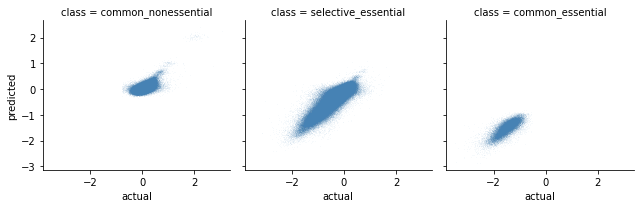

In [494]:
g = sns.FacetGrid(df_merged, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 1, alpha=0.05, linewidth=0, color='steelblue')

[Text(0.5, 0, 'Actual'), Text(0, 0.5, 'Predicted'), (-3.0, 2.0), (-3.0, 2.0)]

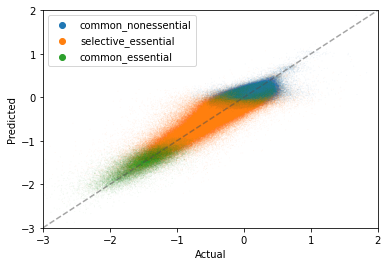

In [495]:
plt.figure()
plt.plot([-3,2], [-3,2], ls="--", c=".3", alpha=0.5)
ax = sns.scatterplot(x='actual', y='predicted', data=df_merged, hue=df_merged['class'].tolist(),
                     s = 1, alpha=0.05, linewidth=0)
ax.set(xlabel='Actual', ylabel='Predicted', xlim=[-3,2], ylim=[-3,2])

### Correlation
Compare the CERES score ranges between actual and predicted

In [496]:
df = pd.concat([range_actual, range_pred], axis=1)
df = df.merge(dep_class, left_index=True, right_index=True)
df.columns = ['actual','predicted','class']

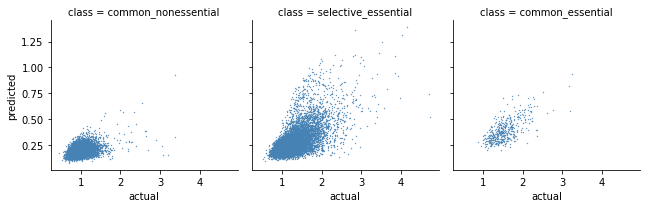

In [497]:
g = sns.FacetGrid(df, col="class")
g.map(sns.scatterplot, 'actual', 'predicted',
      s = 2, alpha=0.8, linewidth=0, color='steelblue')

In [498]:
from scipy.stats import spearmanr
def calcCorr(x):
    a = x.dropna()
    return spearmanr(a['actual'], a['predicted'])
    
df.groupby('class').apply(calcCorr)

class
common_essential       (0.5985273802420971, 2.8637520183922156e-42)
common_nonessential    (0.3260950491728263, 7.452866853531986e-181)
selective_essential                       (0.5714779520025756, 0.0)
dtype: object

### Scores

In [499]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

/Users/boyangzhao/anaconda/envs/cnp/lib/python3.7/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


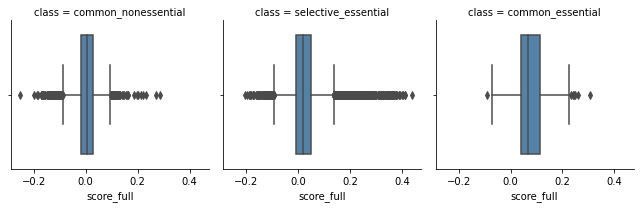

In [500]:
g = sns.FacetGrid(df, col="class")
g.map(sns.boxplot, 'score_full',color='steelblue')

In [501]:
df.groupby('class').apply(np.mean).T

class,common_essential,common_nonessential,selective_essential
score_full,0.076447,0.001858,0.026764
score_rd,-0.002630,-0.083178,-0.055033
score_rd10,-0.000529,-0.083757,-0.055215
corr_rd10,0.188219,0.041948,0.090085
recall_rd10,0.827988,0.598011,0.675500
p19q4_score_rd10,0.009859,-0.095961,-0.070570
p19q4_corr_rd10,0.198079,0.028391,0.074859
p19q4_recall_rd10,0.813219,0.555550,0.626282


In [502]:
df.groupby('class').aggregate(np.median).T

class,common_essential,common_nonessential,selective_essential
score_full,0.06615,0.00333,0.019525
score_rd,-0.01305,-0.07910,-0.061170
score_rd10,-0.00857,-0.07962,-0.061200
corr_rd10,0.18114,0.04063,0.076825
recall_rd10,0.94200,0.63600,0.746000
p19q4_score_rd10,0.01230,-0.08698,-0.070630
p19q4_corr_rd10,0.18705,0.02859,0.064350
p19q4_recall_rd10,0.90700,0.58300,0.684000


### Predicted range

In [503]:
df = df_scores.merge(dep_class, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('class')
df.columns = c

df = df.merge(pred_range, left_index=True, right_index=True)
c = df.columns[:-1].tolist()
c.append('pred_range')
df.columns = c

In [504]:
df['constant'] = df.pred_range<0.45

In [505]:
# number of models in each group that are constant models
df.groupby('class')['constant'].apply(sum)

class
common_essential        313
common_nonessential    7307
selective_essential    9665
Name: constant, dtype: int64

In [506]:
# % of models in each group that are constant models
df.groupby('class')['constant'].apply(lambda x: sum(x)/len(x))

class
common_essential       0.743468
common_nonessential    0.998633
selective_essential    0.921354
Name: constant, dtype: float64